In [1]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense, AvgPool2D, MaxPool2D, MaxPooling2D, AveragePooling2D
from keras.applications.resnet50 import ResNet50, preprocess_input

from PIL import Image, ImageFile

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

<h2> The images directory for training </h2>

In [2]:
DATASET_DIR = r"D:\user\DICOM_images"

<h2> Labels </h2>

In [3]:
category_list = os.listdir(DATASET_DIR)
category_list

['CR-CHEST',
 'CT-ABDOMEN',
 'CT-BREAST',
 'CT-CHEST',
 'CT-COLON',
 'CT-HEADNECK',
 'CT-KIDNEY',
 'CT-LUNG',
 'CT-PANCREAS',
 'DX-CHEST',
 'MG-BREAST',
 'MR-ABDOMEN',
 'MR-BRAIN',
 'MR-BREAST',
 'MR-HEADNECK',
 'MR-KIDNEY',
 'MR-PELVIS',
 'MR-PROSTATE']

<h2> Image size, channels, epcohs, batch size initialize </h2>

In [4]:
IMG_W = 256
IMG_H = 256
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
EPOCHS = 10
BATCH_SIZE = 32

<h2> Crop the image to (256, 256) for convience(The larger the image size, the longer the training takes) </h2>

In [ ]:
from PIL import Image

for root, dirs, files in os.walk(DATASET_DIR):
    rootpath = os.path.join(os.path.abspath(DATASET_DIR), root)

    for file in files:
        try:
            filepath = os.path.join(rootpath, file)
            img = Image.open(filepath)
            img_resize = img.resize((IMG_W, IMG_H))
            img_resize.save(filepath)
            print(filepath + " SUCCESS")
        except:
            print(filepath + " Image Error")

<h2> Some of the label samples have a small number of data and some have a lot -> Causing class imbalance
    <br> - Solution : Using imgaug module to make it balanced -> Image Augmentation </br>
    <br> - Make the original images blur, flip, rotate etc </br></h2>

In [ ]:
from imgaug import augmenters as iaa 
import cv2

def load_images_from_folder(folder): 
    images = [] 
    for filename in os.listdir(folder): 
        img = cv2.imread(os.path.join(folder, filename)) 
        if img is not None: 
            images.append(img) 
    return images

def write_images(folder, name, images): 
    for i in range(0, len(images)): 
        cv2.imwrite(folder + "\\" + name + "{}.png".format(i), images[i])
    print("image saving complete")
        
def augmentations(images):       
    seq1 = iaa.Sequential([
        iaa.AverageBlur(k=(2, 7)),
        iaa.MedianBlur(k = (3, 11))
    ])
    seq2 = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.GaussianBlur(sigma=(0, 3.0))
    ])
    seq3 = iaa.Sequential([
        iaa.AdditiveGaussianNoise(scale=0.05*255),
        iaa.Affine(translate_px={"x": (1, 5)})
    ])
    seq4 = iaa.Sequential([
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True)
    print("image augmentation beginning")
    img1 = seq1.augment_images(images)
    print("sequence 1 completed......")
    img2 = seq2.augment_images(images)
    print("sequence 2 completed......")
    img3 = seq3.augment_images(images)
    print("sequence 3 completed......")
    img4 = seq4.augment_images(images)
    print("sequence 4 completed......")
    print("proceed to next augmentations")
    list = [img1, img2, img3, img4]
    
    return list

<h2> Augment the images which are less then 3000 data <h2>

In [ ]:
for category in category_list:
    category_images_path = os.path.join(DATASET_DIR, category)
    while len(os.listdir(category_images_path)) < 3000:
        images = load_images_from_folder(category_images_path)
        augmented_images = augmentations(images)
        for i in range(len(augmented_images)):
            write_images(category_images_path, "Augmented_", augmented_images[i])

<h2> To load augmented images </h2>

In [5]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

<h2> Using ImageDataGenerator to grow the real-time image (Actually, the purpose of using this model is to increase the number of data)
    <br> - Similar to the previous one, Made the original images rotate, sheer, zoom etc to increase the number of data </br>
    <br> - Split the data to training set and validation set <br>
    <br> - Preprocess the images for better accuracy <br></h2>

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.25,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    validation_split=0.25,
    preprocessing_function=preprocess_input
)

<h2> The path to the directory is passed to create a batch of augmented data </h2>

In [7]:
train_gen = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_W, IMG_H),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_W, IMG_H),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

Found 43328 images belonging to 18 classes.
Found 14435 images belonging to 18 classes.


<h2> Used ResNet50 model to train -> Fixed the ouput to fit my model </h2>

In [8]:
base_model = ResNet50(input_shape=INPUT_SHAPE, weights="imagenet",
                  include_top=False)

x = base_model.output

x = GlobalAveragePooling2D()(x)
output = Dense(len(category_list), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

C:\Users\user\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


<h2> - Perform settings for learning before learning
    <br> - Define loss functions and optimization methods </br></h2>

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

<h2> Show the model's layers and parmeters specifically </h2>

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

<h2> Saving callbacks until the training finish </h2>

In [11]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

MODEL_SAVE_FOLDER_PATH = "./model_2"
LOG_SAVE_FOLDER_PATH = "./logs"
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(LOG_SAVE_FOLDER_PATH):
    os.mkdir(LOG_SAVE_FOLDER_PATH)
model_path = MODEL_SAVE_FOLDER_PATH + "\\" + "{val_accuracy:.2f}-model.h5"

<h2> Start Training </h2>

<h2> Previously, Training accuracy = 98% and Validation accuracy = 94% model was saved
    <br> Now, load the model which is trained </br></h2>

In [12]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = train_gen.samples // BATCH_SIZE,
    validation_data = val_gen,
    validation_steps = val_gen.samples // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [
        ModelCheckpoint(filepath=model_path, monitor="val_accuracy", verbose=1, save_best_only=True),
        TensorBoard(log_dir=LOG_SAVE_FOLDER_PATH, histogram_freq=0, write_graph=True, write_images=True),
        EarlyStopping(monitor="val_accuracy", min_delta=0.6, patience=2, verbose=0)
    ])




Epoch 1/10
1354/1354 [==============================] - 48088s 36s/step - loss: 0.2456 - accuracy: 0.9182 - val_loss: 0.0024 - val_accuracy: 0.9261

Epoch 00001: val_accuracy improved from -inf to 0.92614, saving model to ./model_2\0.93-model.h5

Epoch 2/10
1354/1354 [==============================] - 47762s 35s/step - loss: 0.0841 - accuracy: 0.9692 - val_loss: 0.0000e+00 - val_accuracy: 0.2633

Epoch 00002: val_accuracy did not improve from 0.92614
Epoch 3/10
1354/1354 [==============================] - 45934s 34s/step - loss: 0.0703 - accuracy: 0.9739 - val_loss: 0.1741 - val_accuracy: 0.9278

Epoch 00003: val_accuracy improved from 0.92614 to 0.92779, saving model to ./model_2\0.93-model.h5


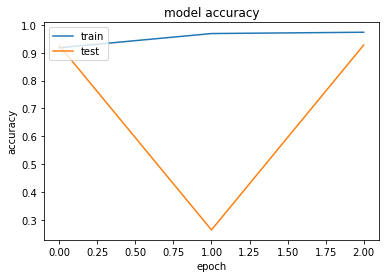

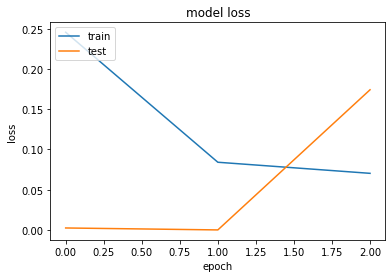

In [16]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.97391987
validation_accuracy 0.9277928471565247


In [18]:
pred = model.predict(val_gen)
predicted_class_indices = np.argmax(pred, axis=1)
labels = (val_gen.class_indices)  
labels2 = dict((v, k) for k, v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)

[ 0  0  0 ... 17 17 17]
{'CR-CHEST': 0, 'CT-ABDOMEN': 1, 'CT-BREAST': 2, 'CT-CHEST': 3, 'CT-COLON': 4, 'CT-HEADNECK': 5, 'CT-KIDNEY': 6, 'CT-LUNG': 7, 'CT-PANCREAS': 8, 'DX-CHEST': 9, 'MG-BREAST': 10, 'MR-ABDOMEN': 11, 'MR-BRAIN': 12, 'MR-BREAST': 13, 'MR-HEADNECK': 14, 'MR-KIDNEY': 15, 'MR-PELVIS': 16, 'MR-PROSTATE': 17}
['CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'DX-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'DX-CHEST', 'CR-CHEST', 'DX-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'DX-CHEST', 'CR-CHEST', 'CR-CHEST', 'DX-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'DX-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'DX-CHEST', 'CR-CHEST', 'CR-CHEST', 'CR-CHEST', 'DX-CHEST', 'CR-CHEST', 'CR

In [19]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(predicted_class_indices, label)

In [20]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=["Actual"], colnames=["Predicted"], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,All
Actual,,,,,,,,,,,,,,,,,,,
0,630,0,0,3,0,0,0,0,0,151,0,0,0,0,0,0,0,0,784
1,0,810,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,810
2,0,0,847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,847
3,163,0,0,280,2,384,0,0,1,0,0,0,0,0,0,0,0,0,830
4,1,0,0,24,728,0,0,0,0,0,0,0,0,0,0,0,0,0,753
5,0,0,0,0,0,767,0,0,0,0,0,0,0,0,0,0,0,0,767
6,0,0,0,16,0,0,774,0,18,0,0,0,0,0,0,0,0,0,808
7,0,0,0,0,0,0,0,765,0,0,0,0,0,0,0,0,0,0,765
8,0,0,0,30,1,0,1,0,791,0,0,0,1,0,0,1,0,0,825


In [ ]:
from keras.models import load_model

loaded_model = load_model(os.path.join("model", "0.94-model.h5"))

<h2> Check the accuracy, when the new dataset comes </h2>

In [13]:
label = val_gen.classes

<h2> Visualize what did you predicted correctly (Matrix) </h2>

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(predicted_class_indices,label)
cf

In [ ]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

<h2> Example of predict new data </h2>

In [ ]:
test_dicom = r"D:\DICOM_data\BREAST-DIAGNOSIS\BreastDx-01-0001\08-12-2008-MRI Breast Bilateral with and without Contrast-44317\401.000000-T2WTSE SENSE-75663\1-10.dcm"

In [ ]:
import pydicom

test_file = pydicom.dcmread(test_dicom)
plt.axis("off")
plt.imsave(os.path.join(os.getcwd(), "images", str(test_file.Modality) + "-" + str(test_file.SOPInstanceUID) + ".png"), 
           test_file.pixel_array)
test_img = os.path.join(os.getcwd(), "images", str(test_file.Modality) + "-" + str(test_file.SOPInstanceUID) + ".png")

In [ ]:
img = Image.open(test_img)
img_resize = img.resize((IMG_W, IMG_H))
img_resize.save(test_img)

In [ ]:
test_img = img_to_array(load_img(test_img,
                                 target_size=(256, 256)))
test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

In [ ]:
pred = loaded_model.predict(test_input)
predicted_class_indices = np.argmax(pred, axis=1)
labels = dict((k, v) for k, v in enumerate(category_list))
print(pred)
print(labels)
predicted_class_indices = int(predicted_class_indices)

In [ ]:
def window_image(img, window_center, window_width, slope, intercept):
    img = (img * slope + intercept)
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    
    return np.clip(img, img_min, img_max)

In [ ]:
try:
    test_img = window_image(test_file.pixel_array, test_file.WindowCenter[0], test_file.WindowWidth[0], test_file.RescaleSlope, 
                        test_file.RescaleIntercept)
    plt.figure(figsize=(8, 8))
    plt.title(labels[predicted_class_indices] + ' %.3f%%' % (pred[0][predicted_class_indices] * 100))
    plt.imshow(test_img.astype(np.uint8), cmap=plt.cm.gray)
    plt.show()
except TypeError as te:
    if test_file.Modality == "MG" and test_file.BodyPartExamined == "BREAST":
        test_file.WindowWidth = 65535
        test_file.WindowCenter = 32767
        test_img = window_image(test_file.pixel_array, test_file.WindowCenter, test_file.WindowWidth, test_file.RescaleSlope, 
                        test_file.RescaleIntercept)
    plt.figure(figsize=(8, 8))
    plt.title(labels[predicted_class_indices] + ' %.3f%%' % (pred[0][predicted_class_indices] * 100))
    plt.imshow(test_img.astype(np.uint8), cmap=plt.cm.gray)
    plt.show()